In [2]:
# Add the root path of the pyqula library
import os ; import sys
sys.path.append(os.environ["PYQULAROOT"])

# some default parameters in matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['font.size'] = 20
plt.rcParams['image.cmap'] = 'coolwarm'

import numpy as np

# Magnetism
In this session we will address several examples about magnetism in 2D materials

### Contents
- Symmetry breaking by magnetic interactions
- The strong coupling limit of a magnetic system
- Intermediate coupling regime and Stoner instability
- Non-collinear magnetism from competing interactions
- Non-collinear magnetism from spin-orbit coupling
- Non-collinear magnetism from magnetic frustration
- Charge-magnetic coupling

### Learning outcomes
- Understand the impact of electronic repulsion in an electronic structure
- Rationalize the intermediate and strong coupling regimes of an interacting magnetic system
- Understand mechanism leading to non-collinear magnetism
- Rationalize the interplay between charge and magnetic order

## Magnetic order driven by interactions
We will start showing the magnetic instabilities of a 1D chain at half filling, with two sites per unit cell

([], [])

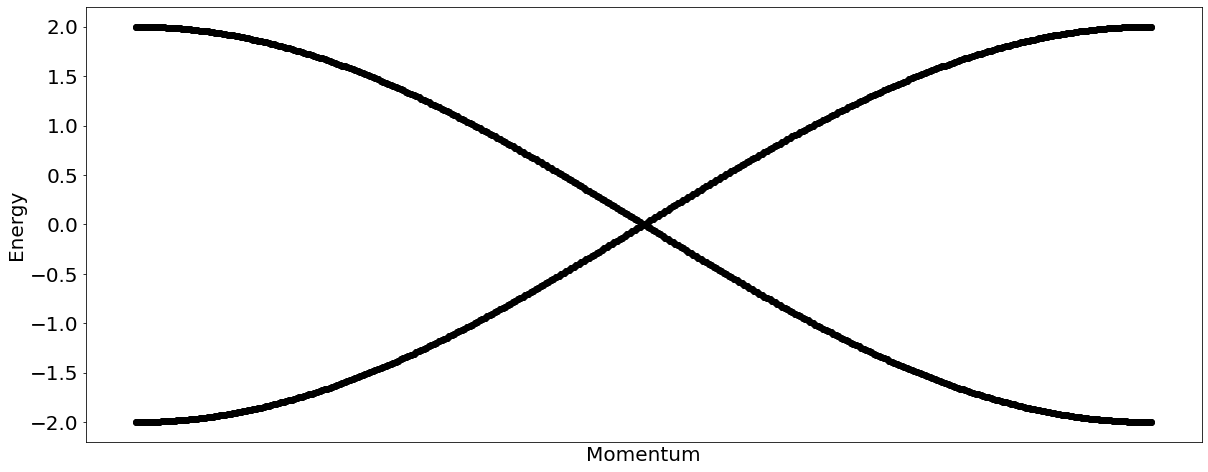

In [3]:
from pyqula import geometry
g = geometry.bichain() # generate a chain with two sites per unit cell
h = g.get_hamiltonian() # generate the Hamiltonian
(k,e) = h.get_bands() # compute band structure
plt.scatter(k,e,c="black") ; plt.xlabel("Momentum") ; plt.ylabel("Energy") ; plt.xticks([]) # plot

(-3.85, 3.85, -0.05500000000000001, 0.05500000000000001)

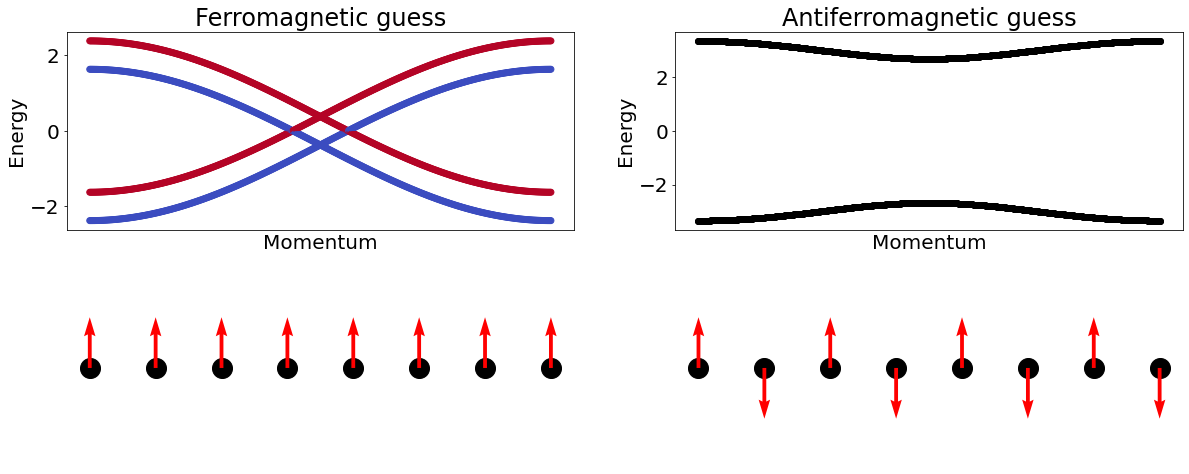

In [57]:
# let us now add interactions, and compute the electronic structure
g = geometry.bichain() # generate a chain with two sites per unit cell
h = g.get_hamiltonian() # generate the Hamiltonian

U = 6.0 # value of the local interaction

# first with a ferromagnetic guess
plt.subplot(2,2,1)
plt.title("Ferromagnetic guess")
hfe = h.get_mean_field_hamiltonian(U=U,mf="ferro") # solve the interacting problem with a mean-field guess
(k,e,c) = hfe.get_bands(operator="sz") # compute band structure
plt.scatter(k,e,c=c) ; plt.xlabel("Momentum") ; plt.ylabel("Energy") ; plt.xticks([]) # plot

# plot magnetization
hs = hfe.get_supercell(4) ; gs = hs.geometry ; mz = hs.extract("mz") # supercell geometry and Mz
plt.subplot(2,2,3)
mz = hs.extract("mz") ; x = gs.r[:,0] ; y = gs.r[:,1] 
mz = mz/np.max(np.abs(mz)) # normalize
plt.scatter(x,y,c="black",s=400) ; plt.quiver(x,y,0.,mz,color="red",scale=10) ; plt.axis("off") # plot

# and with an antiferromagnetic guess
plt.subplot(2,2,2)
plt.title("Antiferromagnetic guess")
haf = h.get_mean_field_hamiltonian(U=U,mf="antiferro") # solve the interacting problem with a mean-field guess
(k,e) = haf.get_bands() # compute band structure
plt.scatter(k,e,c="black") ; plt.xlabel("Momentum") ; plt.ylabel("Energy") ; plt.xticks([]) # plot

# plot magnetization
hs = haf.get_supercell(4) ; gs = hs.geometry ; mz = hs.extract("mz") # supercell geometry and Mz
plt.subplot(2,2,4)
mz = hs.extract("mz") ; x = gs.r[:,0] ; y = gs.r[:,1] 
mz = mz/np.max(np.abs(mz)) # normalize
plt.scatter(x,y,c="black",s=400) ; plt.quiver(x,y,0.,mz,color="red",scale=10) ; plt.axis("off") # plot

### Exercise
- Discuss which solution you think it has the lowest energy, and why
- Compute the selfconsistent solution for stronger values of the interaction. Which change do you observe?

## The strong coupling limit
Let us now compare the energies of a ferromagnetic and antiferromagnetic state in the strong coupling limit

Text(0, 0.5, 'Energy FE - AF')

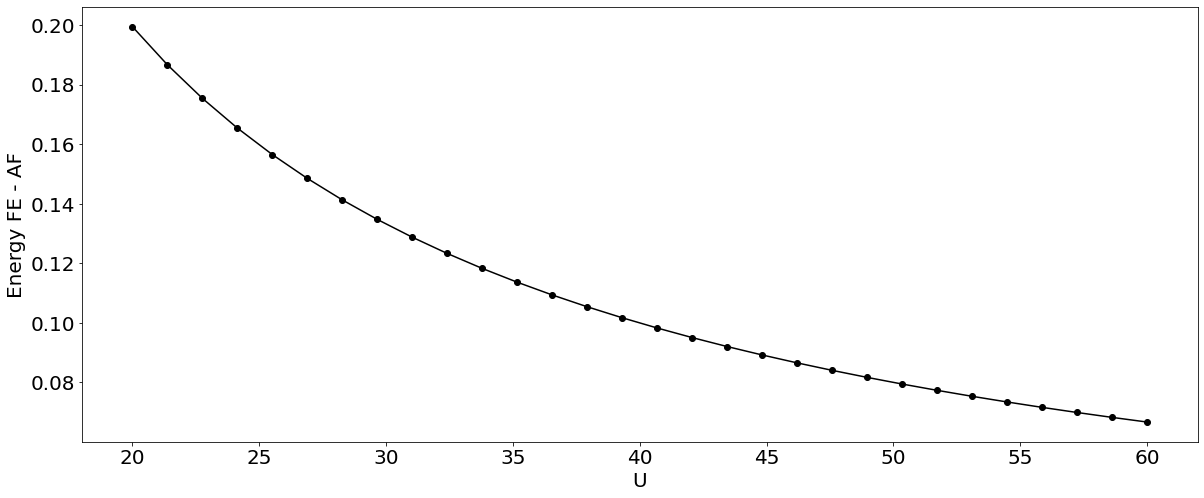

In [4]:
# let us now compute the energy difference as a function of U
def get_energy_difference(U):
    g = geometry.bichain() # generate a chain with two sites per unit cell
    h = g.get_hamiltonian() # generate the Hamiltonian
    (hfe,efe) = h.get_mean_field_hamiltonian(U=U,return_total_energy=True,mf="ferro",mix=0.9) # FE
    (haf,eaf) = h.get_mean_field_hamiltonian(U=U,return_total_energy=True,mf="antiferro",mix=0.9) # AF
    return efe - eaf

Us = np.linspace(20.,60,30) # values of U considered

Et = [get_energy_difference(U) for U in Us] # energy differences

plt.plot(Us,Et,c="black",marker="o") # plot total energy VS value of U
plt.xlabel("U") ; plt.ylabel("Energy FE - AF")

### Exercise
- Discuss why the dependence of 1/U is observed in the energy differences between FE and AF configurations
- Compute this very same curve but going to lower values of U. Why does the 1/U behavior break down?

## Intermediate coupling regime and Stoner instability
Let us now show how there is a critical value of the electronic interaction to develop time-reversal symmetry breaking

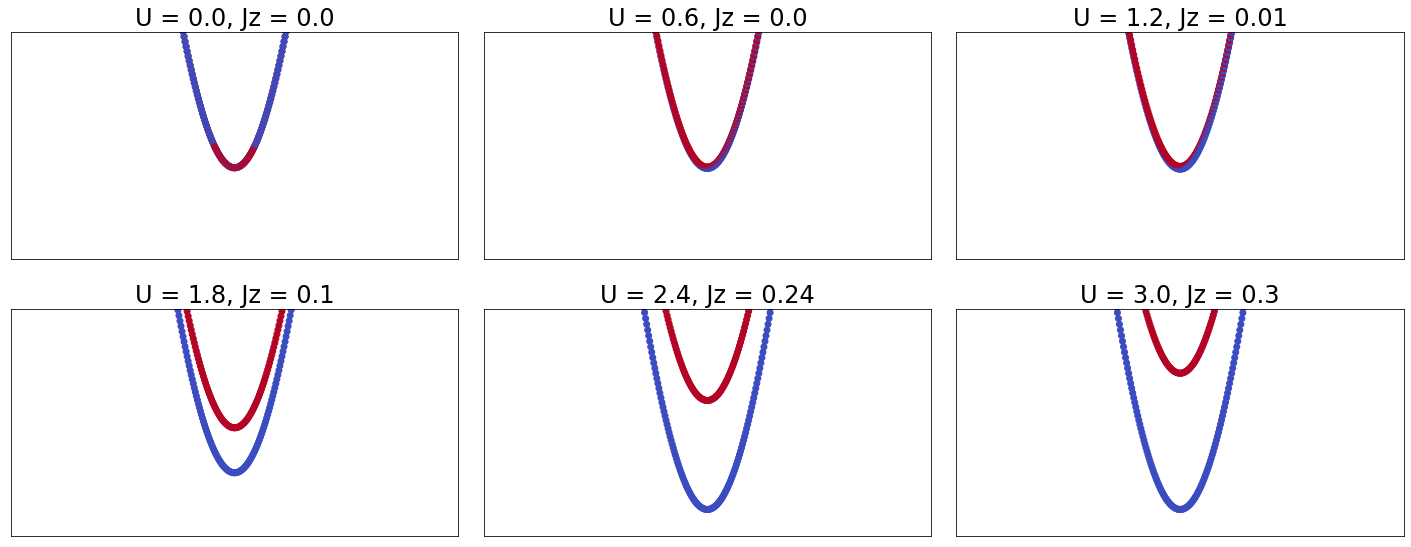

In [91]:
N = 6 # number of plots
Us = np.linspace(0.,3.0,N) # strengths of electronic interaction

ii = 1 # counter for the subplots
for U in Us:
    g = geometry.chain() # generate a chain
    h = g.get_hamiltonian() # generate the Hamiltonian
    h = h.get_mean_field_hamiltonian(U=U,filling=0.1,mf="ferro",mix=0.9,nk=200) # perform SCF
    plt.subplot(N//3,3,ii); ii += 1 
    (k,e,c) = h.get_bands(operator="sz") # compute band structure
    jz = np.mean(np.abs(h.extract("mz"))) # magnetization
    plt.title("U = "+str(np.round(U,2))+", Jz = "+str(np.round(jz,2))) # set the title
    plt.scatter(k,e,c=c) ; plt.yticks([]) ; plt.xticks([]) ; plt.ylim([-.5,.5]) # plot
plt.tight_layout() # adjust the subplots

### Exercise
- Perform the calculation at a smaller filling (0.05 for example). Does the critical value increase or decrease?
- Perform the calculation at a bigger filling (0.2 for example). Does the critical value increase or decrease?
- Discuss why the critical value leading to magnetism changes

## Magnetism in flat bands
Let us now show the emergence of magnetic instabilities in a flat band system. For that, we will put a vacancy in a honeycomb lattice, which gives rise to a flat zero mode

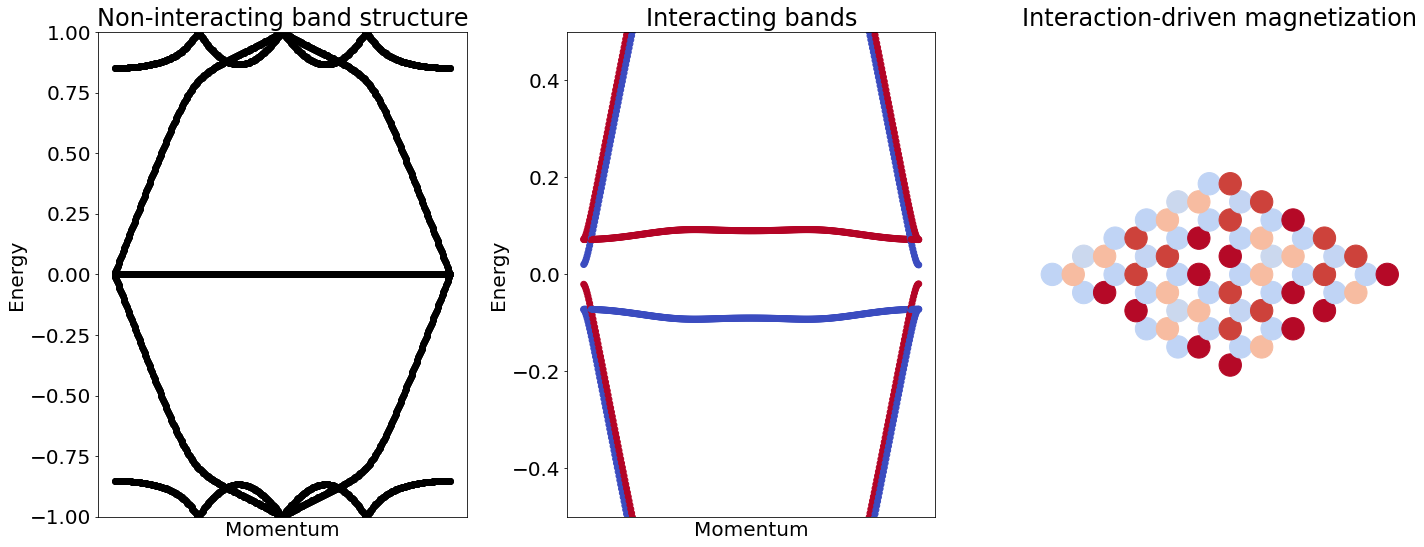

In [62]:
g = geometry.honeycomb_lattice() # generate a honeycomb lattice
N=3 ; g = g.get_supercell((N,N)) ; g = g.remove(0) # make a supercell and remove a site

# first plot the non-interacting bands
plt.subplot(1,3,1) ; plt.title("Non-interacting band structure")
h = g.get_hamiltonian() # generate the Hamiltonian
(k,e) = h.get_bands() # compute band structure
plt.scatter(k,e,c="black") ; plt.xlabel("Momentum") ; plt.ylabel("Energy") ; plt.xticks([]) ; plt.ylim([-1.,1.])# plot

# compute the mean-field Hamiltonian
U = 1.0 # value of the interaction
hscf = h.get_mean_field_hamiltonian(U=U,mix=0.9,mf="ferro") # perform mean-field

# plot the interacting bands
plt.subplot(1,3,2) ; plt.title("Interacting bands")
(k,e,c) = hscf.get_bands(operator="sz") # compute band structure
plt.scatter(k,e,c=c) ; plt.xlabel("Momentum") ; plt.ylabel("Energy") ; plt.xticks([]) ; plt.ylim([-.5,.5])# plot

# plot the selfconsistent magnetization
plt.subplot(1,3,3) ; plt.title("Interaction-driven magnetization")
hs = hscf.get_supercell(2) ; gs = hs.geometry ; mz = hs.extract("mz") # supercell geometry and Mz
plt.scatter(gs.r[:,0],gs.r[:,1],c=mz,vmin=-.1,vmax=.1,s=500) ; plt.axis("off") ; plt.axis("equal")

plt.tight_layout() # adjust subplots

### Exercise
- Change the value of the interaction U. Do you have an instability also for smaller U?
- Discuss how this can be understood in terms of the Stoner instability
- Take a different supercell N, and discuss if you observe flat bands and interaction-induced magnetization
- Replace the honeycomb lattice by a square lattice with even N. Show that flat bands and a magnetization appears in the unit cell

## Non-collinear magnetism from competing interactions
Let us now include further neighbor hoppings, which promotes competing magnetic interactions

(-10.45, 10.45, -0.05500000000000001, 0.05500000000000001)

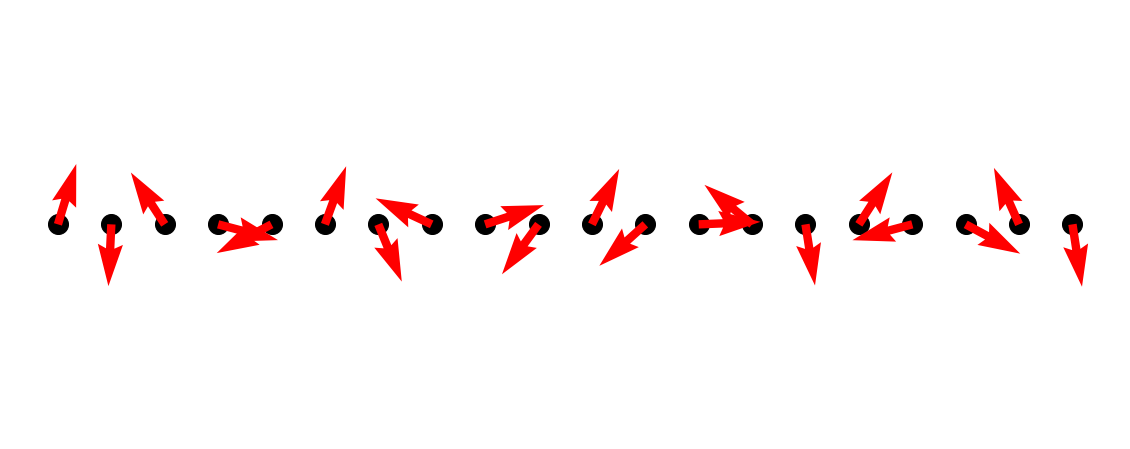

In [12]:
from pyqula import geometry
g = geometry.chain() # generate a chain 
g = g.get_supercell(20) ; g.dimensionality = 0 # use open boundaries, to avoid incommensurability issues
h = g.get_hamiltonian(tij=[1.,.6]) # generate the Hamiltonian

# generate the SCF Hamiltonian
U = 10. # strong Hubbard interaction
h = h.get_mean_field_hamiltonian(U=U,mf="XY",mix=0.9) # solve the interacting problem with a mean-field guess
mx = h.extract("mx") ; my = h.extract("my") ; x = h.geometry.r[:,0] ; y = h.geometry.r[:,1] # get magnetization
plt.scatter(x,y,c="black",s=400) ; plt.quiver(x,y,mx,my,color="red") ; plt.axis("off") # plot magnetization

### Exercise
- Discuss why including second neighbor hopping gives rise to a non-collinear magnetic state
- Is there a long neighbor hopping that can be included that does not lead to non-collinearity? Include it and show that you recover the antiferromagnetic state

## Non-collinear magnetism from spin-orbit coupling
We will now see that spin-orbit coupling is also able to generate a non-collinear magnetic texture

(-4.95, 4.95, -0.05500000000000001, 0.05500000000000001)

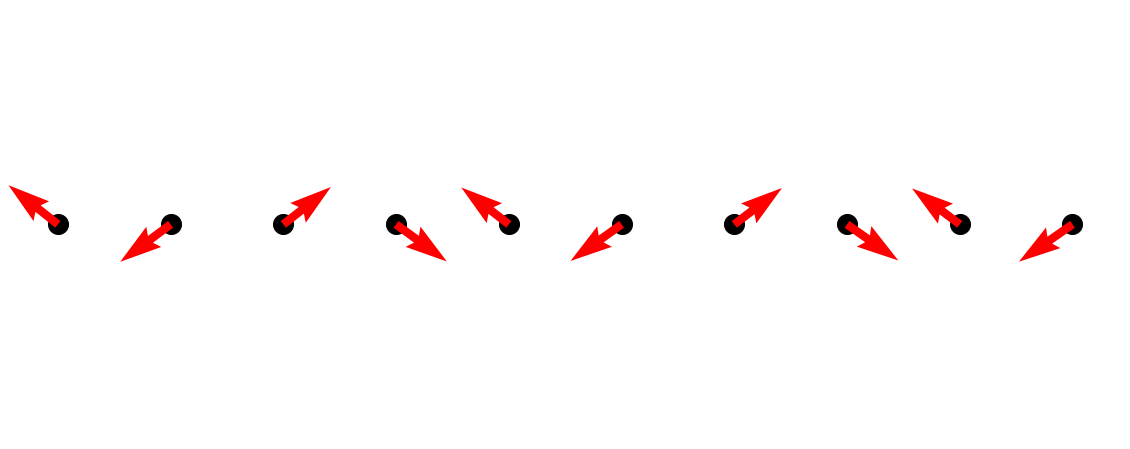

In [34]:
from pyqula import geometry
g = geometry.chain() # generate a chain 
g = g.get_supercell(10) ; g.dimensionality = 0 # use open boundaries, to avoid incommensurability issues
h = g.get_hamiltonian() # generate the Hamiltonian
h.add_rashba(1.) # add Rashba spin-orbit coupling

# generate the SCF Hamiltonian
U = 10. # strong Hubbard interaction
h = h.get_mean_field_hamiltonian(U=U,mf="random",mix=0.9) # solve the interacting problem with a mean-field guess
mx = h.extract("mx") ; my = h.extract("my") ; x = h.geometry.r[:,0] ; y = h.geometry.r[:,1] # get magnetization
plt.scatter(x,y,c="black",s=400) ; plt.quiver(x,y,mx,my,color="red") ; plt.axis("off") # plot magnetization

### Exercise
- Discuss why spin-orbit coupling gives rise to non-collinear magnetism
- What is the effective term in the Hamiltonian that SOC generates?

## Magnetic instabilities of the square lattice
Let us now address the magnetic instabilities of the square lattice

(-1.65, 1.65, -1.65, 1.65)

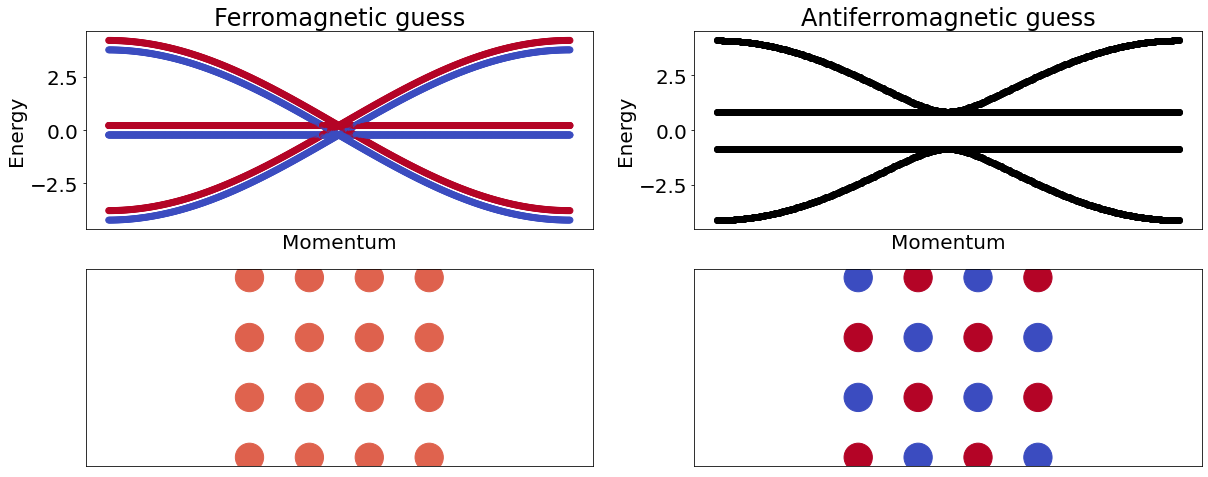

In [62]:
g = geometry.square_lattice_bipartite() # generate a chain with two sites per unit cell
h = g.get_hamiltonian() # generate the Hamiltonian

# let us now add interactions, and compute the electronic structure
U = 3.0 # value of the local interaction

# first with a ferromagnetic guess
plt.subplot(2,2,1)
plt.title("Ferromagnetic guess")

hfe = h.get_mean_field_hamiltonian(U=U,mf="ferro",mix=0.9) # FE guess
(k,e,c) = hfe.get_bands(operator="sz") # compute band structure
plt.scatter(k,e,c=c) ; plt.xlabel("Momentum") ; plt.ylabel("Energy") ; plt.xticks([]) # plot

# plot z-component of the magnetization
hs = hfe.get_supercell(2) ; gs = hs.geometry ; mz = hs.extract("mz") # supercell geometry and Mz
plt.subplot(2,2,3)
plt.scatter(gs.r[:,0],gs.r[:,1],c=mz,vmin=-.3,vmax=.3,s=800) ; plt.yticks([]) ; plt.xticks([]) ; plt.axis("equal")

# and with an antiferromagnetic guess
plt.subplot(2,2,2)
plt.title("Antiferromagnetic guess")
haf = h.get_mean_field_hamiltonian(U=U,mf="antiferro",mix=0.9) # AF guess
(k,e) = haf.get_bands() # compute band structure
plt.scatter(k,e,c="black") ; plt.xlabel("Momentum") ; plt.ylabel("Energy") ; plt.xticks([]) # plot

# plot z-component of the magnetization
hs = haf.get_supercell(2) ; gs = hs.geometry ; mz = hs.extract("mz") # supercell geometry and Mz
plt.subplot(2,2,4)
plt.scatter(gs.r[:,0],gs.r[:,1],c=mz,vmin=-.3,vmax=.3,s=800) ; plt.yticks([]) ; plt.xticks([]) ; plt.axis("equal")

## Non-collinear magnetic order from geometric frustration
We will now address 2D models that show non-collinear magnetism due to the geometric frustration of the lattice.

(-4.124999999999999, 4.124999999999999, -2.3815698604072066, 2.381569860407206)

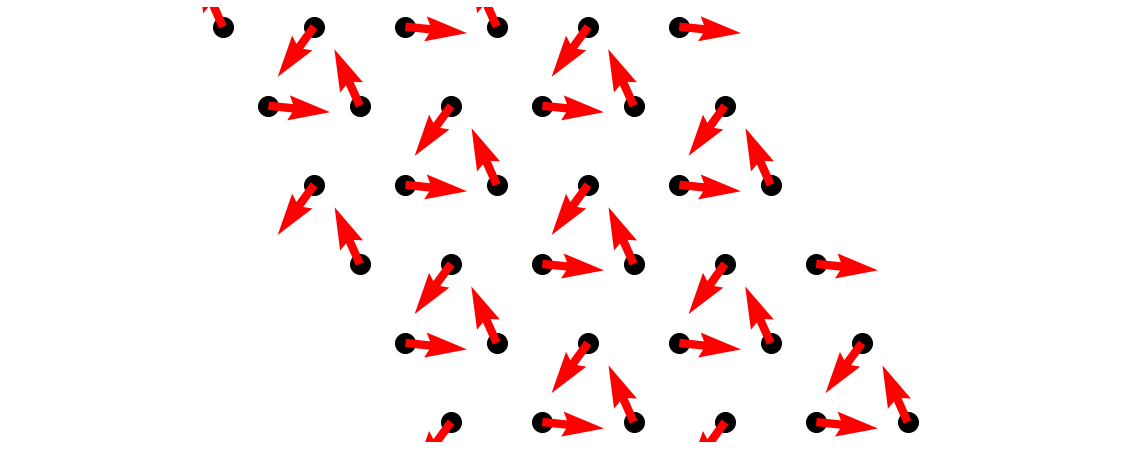

In [20]:
from pyqula import geometry
g = geometry.triangular_lattice() # generate a chain 
g = g.get_supercell((3,3)) # make a supercell
h = g.get_hamiltonian() # generate the Hamiltonian

# generate the SCF Hamiltonian
U = 10. # strong Hubbard interaction
h = h.get_mean_field_hamiltonian(U=U,mf="XY",mix=0.9) # solve the interacting problem with a mean-field guess
hs = h.get_supercell(2) # generate a supercell
mx = hs.extract("mx") ; my = hs.extract("my") ; x = hs.geometry.r[:,0] ; y = hs.geometry.r[:,1] # get magnetization
plt.scatter(x,y,c="black",s=400) ; plt.quiver(x,y,mx,my,color="red")  # plot magnetization
plt.axis("equal") ; plt.axis("off")

### Exercise
- Plot the band structure for the SCF solution for the 3x3 supercell, and estimate its gap
- Plot the band structure for the SCF solution for the 1x1 supercell, and estimate its gap
- Can you infer which one is the lowest energy solution, and why?

## Competition between interactions
Let us now address the magnetic instabilities of the honeycomb lattice, and see the interplay between charge and spin order

([], [])

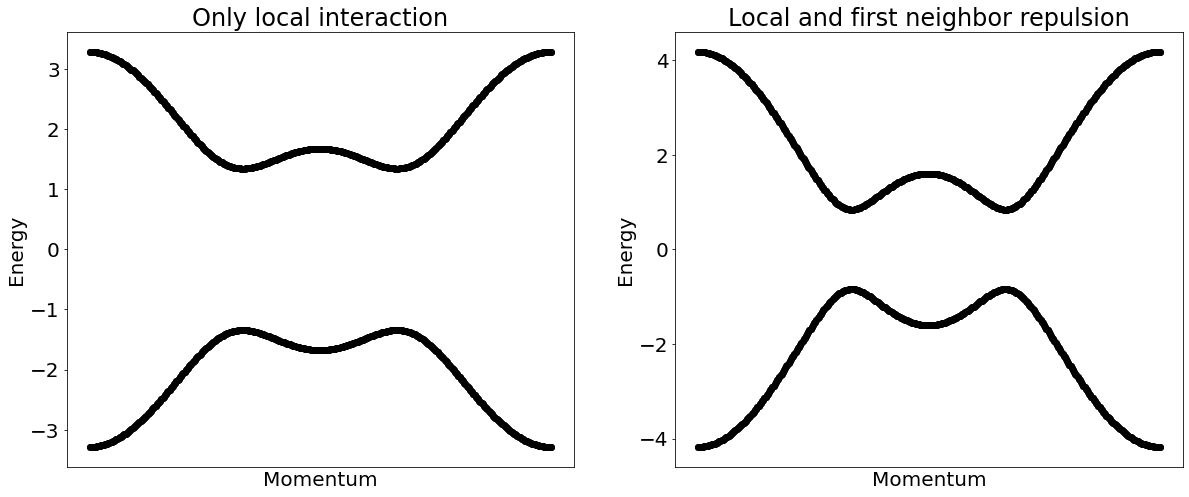

In [7]:
g = geometry.honeycomb_lattice() # generate a chain with two sites per unit cell
h = g.get_hamiltonian() # generate the Hamiltonian

# let us now add interactions, and compute the electronic structure
U = 4.0 # value of the local interaction
V = 1.5 # value of the first neighbor interaction

# first with U
plt.subplot(1,2,1)
plt.title("Only local interaction")
hU = h.get_mean_field_hamiltonian(U=U,mf="antiferro",mix=0.9) # only U
(k,e) = hU.get_bands() # compute band structure
plt.scatter(k,e,c="black") ; plt.xlabel("Momentum") ; plt.ylabel("Energy") ; plt.xticks([]) # plot

# and with U and V
plt.subplot(1,2,2)
plt.title("Local and first neighbor repulsion")
hUV = h.get_mean_field_hamiltonian(U=U,V1=V,mf="antiferro",mix=0.9) # U and V
(k,e) = hUV.get_bands() # compute band structure
plt.scatter(k,e,c="black") ; plt.xlabel("Momentum") ; plt.ylabel("Energy") ; plt.xticks([]) # plot

### Exercise
- Discuss what is the impact of first neighbor repulsion. Is it promoting or quenching magnetic order?
- Take a value of U slightly above the critical one (U=2.3), and add a small first neighbor repulsion. Do you observe magnetic order?

## Competition between charge and magnetic order in the honeycomb lattice
Let us now look in more detail at the interacting honeycomb lattice. In particular, we will see what is the interplay between U and V, showing that U promotes magnetic order and V promotes charge order

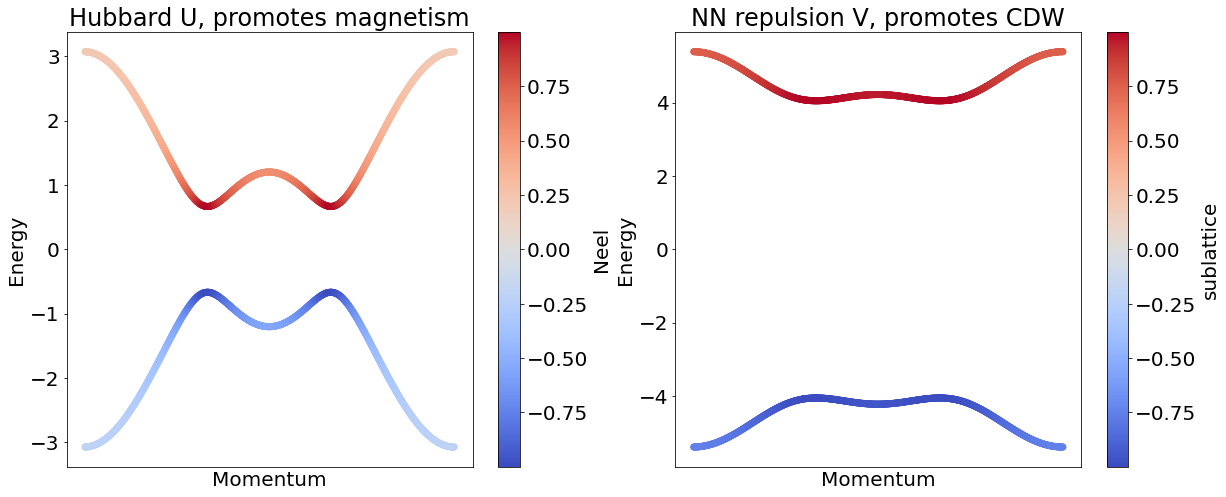

In [45]:
from pyqula import geometry
g = geometry.honeycomb_lattice() # generate a chain with two sites per unit cell
h = g.get_hamiltonian() # generate the Hamiltonian

# let us now add interactions, and compute the electronic structure
U = 3.0 # value of the local interaction
V = 1.5 # value of the first neighbor interaction

# first with U
plt.subplot(1,2,1)
plt.title("Hubbard U, promotes magnetism")
hU = h.get_mean_field_hamiltonian(U=U,mf="antiferro",mix=0.9) # only U
op = h.get_operator("sz")*h.get_operator("sublattice") # Sz times sublattice
(k,e,c) = hU.get_bands(operator=op) # compute band structure
plt.scatter(k,e,c=c) ; plt.xlabel("Momentum") ; plt.ylabel("Energy") ; plt.xticks([]) # plot
plt.colorbar(label="Neel") # plot

# and with U and V
plt.subplot(1,2,2)
plt.title("NN repulsion V, promotes CDW")
hUV = h.get_mean_field_hamiltonian(V1=V,mf="random",mix=0.9) # U and V
(k,e,c) = hUV.get_bands(operator="sublattice") # compute band structure
plt.scatter(k,e,c=c) ; plt.xlabel("Momentum") ; plt.ylabel("Energy") ; plt.xticks([]) 
plt.colorbar(label="sublattice") # plot

### Exercise
- Replace the sublattice*mz operator in Hubbard case, by the sublattice operator. What do you observe?
- Replace the sublattice operator in V-interaction case, by the sublattice*mz operator. What do you observe?


## Simultaneous charge and magnetic ordering in the honeycomb lattice
Let us now impose the existence of both charge order and magnetism in the honeycomb lattice

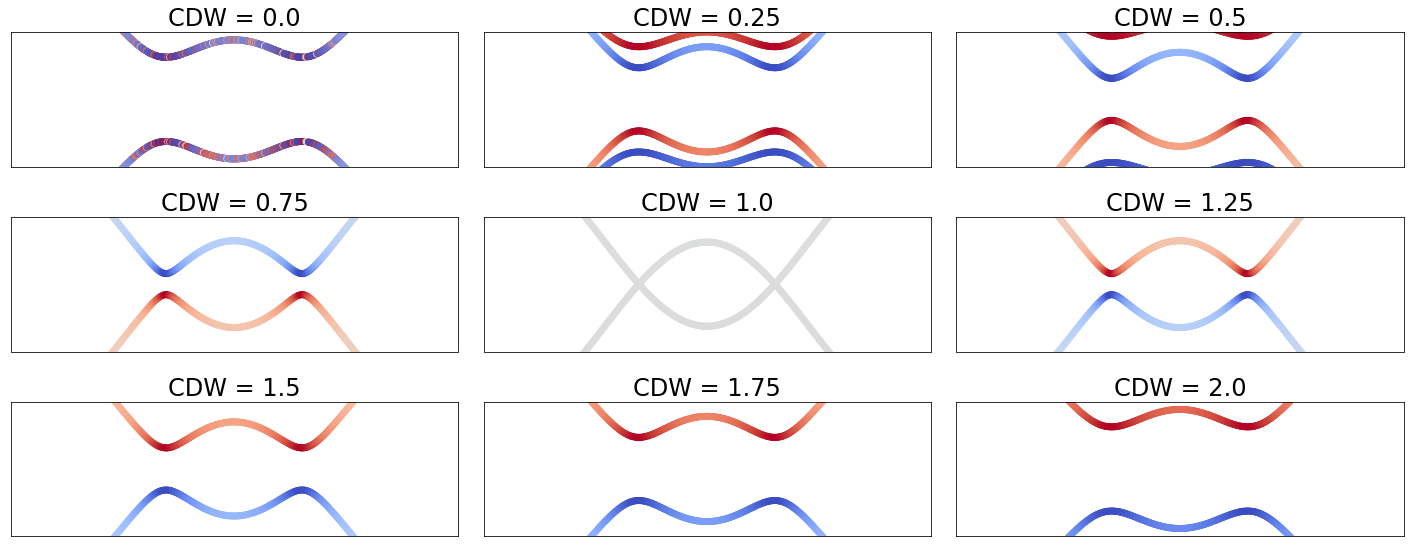

In [93]:
N = 9 # number of plots
cdws = np.linspace(0.,2.0,N) # strengths

ii = 1 # counter for the subplots
for cdw in cdws:
    g = geometry.honeycomb_lattice() # generate a chain
    h = g.get_hamiltonian() # generate the Hamiltonian
    h.add_sublattice_imbalance(cdw) # Add a CDW order explicitly
    h.add_antiferromagnetism(1.0) # add antiferromagnetism explicitly
    plt.subplot(N//3,3,ii); ii += 1 
    (k,e,c) = h.get_bands(operator="sublattice") # compute band structure
    plt.title("CDW = "+str(np.round(cdw,2))) # set the title
    plt.scatter(k,e,c=c) ; plt.yticks([]) ; plt.xticks([]) ; plt.ylim([-1.6,1.6]) # plot
plt.tight_layout() # adjust the subplots

### Exercise
- Given a certain value of the AF order, what is the value of the CDW required to close the gap?
- Discuss why it is energetically unfavorable to have simultaneously antiferromagnetism and charge density wave order